In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Loading Train & Test Datasets

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9308 files belonging to 5 classes.
Using 7447 files for training.
Found 9308 files belonging to 5 classes.
Using 1861 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Fetal-abdomen', 'Fetal-femur', 'Fetal-thorax', 'Maternal-cervix', 'Other']


##Visualizing Dataset

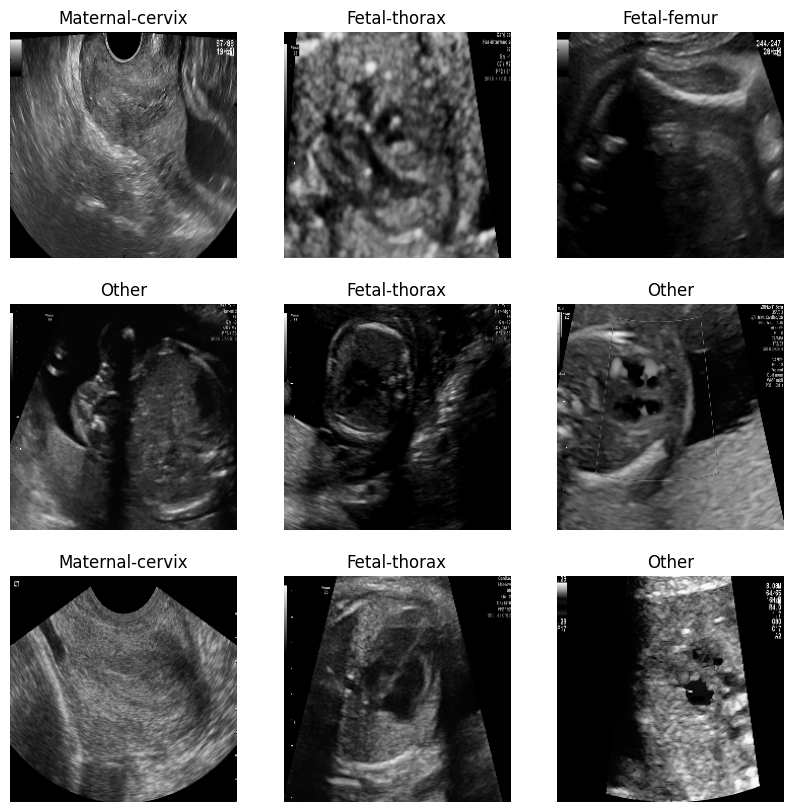

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Normalizing Datasets

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

## Train + Eval Of Model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
233/233 [==============================] - 3247s 4s/step - loss: 0.5807 - accuracy: 0.7876 - val_loss: 0.3997 - val_accuracy: 0.8404
Epoch 2/10
233/233 [==============================] - 481s 2s/step - loss: 0.3235 - accuracy: 0.8804 - val_loss: 0.3686 - val_accuracy: 0.8657
Epoch 3/10
233/233 [==============================] - 483s 2s/step - loss: 0.2057 - accuracy: 0.9286 - val_loss: 0.4460 - val_accuracy: 0.8538
Epoch 4/10
233/233 [==============================] - 478s 2s/step - loss: 0.1154 - accuracy: 0.9586 - val_loss: 0.4481 - val_accuracy: 0.8565
Epoch 5/10
233/233 [==============================] - 479s 2s/step - loss: 0.0691 - accuracy: 0.9766 - val_loss: 0.5816 - val_accuracy: 0.8490
Epoch 6/10
233/233 [==============================] - 481s 2s/step - loss: 0.0386 - accuracy: 0.9894 - val_loss: 0.6276 - val_accuracy: 0.8598
Epoch 7/10
233/233 [==============================] - 489s 2s/step - loss: 0.0372 - accuracy: 0.9903 - val_loss: 0.5832 - val_accuracy: 0.850

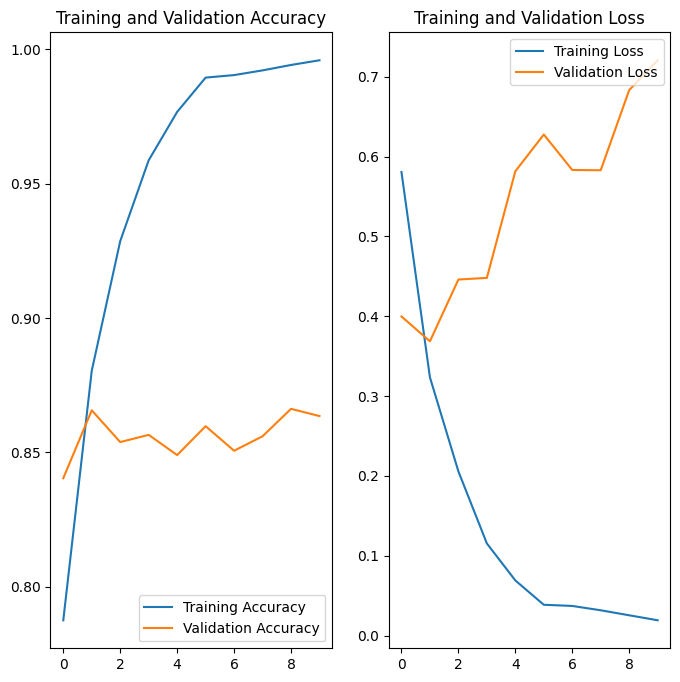

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Saving Current Model (Optional)

In [ ]:
#model.save('fetal_img_model.h5')

##Predict on new data

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/FYP-XAI/fetal_img_model.h5') #Load Model

In [ ]:
def predict_new_images(img_paths,model):

  final_preds = []
  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in img_paths:

    ground_value = i.split('/')[6]

    img = tf.keras.utils.load_img(
      i, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = new_model.predict(img_array,verbose=0)
    score = tf.nn.softmax(predictions[0])

    print(
        "Actual - {} | Predicted - {} with a {:.2f} percent confidence."
        .format(ground_value,class_names[np.argmax(score)], 100 * np.max(score))
    )

    pred_title = "{}-{:.2f}%".format(class_names[np.argmax(score)], 100 * np.max(score))

    ax = fig.add_subplot(1, len(img_paths), cnt+1)
    plt.imshow((plt.imread(i)), cmap='gray')
    plt.axis('off')
    plt.title(pred_title)
    cnt+=1

    tup = (f'{class_names[np.argmax(score)]}-{(100 * np.max(score)):.2f} %', img_array)
    final_preds.append(tup)


  return final_preds

Actual - Fetal-abdomen | Predicted - Fetal-abdomen with a 100.00 percent confidence.
Actual - Fetal-thorax | Predicted - Fetal-thorax with a 99.99 percent confidence.
Actual - Fetal-femur | Predicted - Fetal-femur with a 100.00 percent confidence.
Actual - Maternal-cervix | Predicted - Maternal-cervix with a 100.00 percent confidence.
Actual - Other | Predicted - Other with a 100.00 percent confidence.


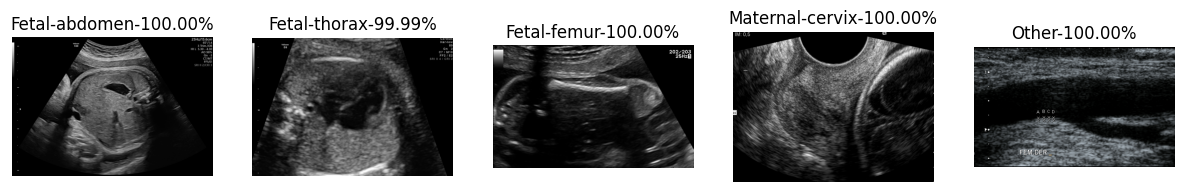

In [ ]:
#Add Image Paths into the array for prediction

images_to_predict = [

    # Fetal Abdomen - 3 (num_feat)

    # '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-abdomen/Patient01789_Plane2_2_of_2.png',
    # '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-abdomen/Patient00960_Plane2_2_of_4.png',
    '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-abdomen/Patient01530_Plane2_1_of_2.png',


    # Fetal Thorax - 8/5 (num_feat)

    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-thorax/Patient00811_Plane6_1_of_3.png',
    '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-thorax/Patient00817_Plane6_6_of_8.png',


    # Fetal Femur - 3 (num_feat)

    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-femur/Patient00168_Plane5_1_of_2.png',
    '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Fetal-femur/Patient00188_Plane5_1_of_1.png',

    #Maternal Cervix - 8 (num_feat)

    '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Maternal-cervix/Patient00057_Plane4_3_of_3.png',
    #'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Maternal-cervix/Patient00239_Plane4_1_of_1.png',


    #Other

    '/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Other/Patient00001_Plane1_11_of_15.png',
    ##'/content/drive/MyDrive/FYP-XAI/FETAL_PLANES_ZENODO/Other/Patient00002_Plane1_12_of_20.png',

]

final_preds = predict_new_images(images_to_predict,new_model)

##Using LIME for Explanations

In [ ]:
!pip install lime &> /dev/null

In [ ]:
import lime
from lime import lime_image
from lime import submodular_pick
from skimage.segmentation import mark_boundaries

In [ ]:
def explainer_predict_fn(img_array):
  return new_model.predict(img_array,verbose = 0)

In [ ]:
def lime_exp(img_array,model):

  explainer = lime_image.LimeImageExplainer()
  exp = explainer.explain_instance(img_array[0].numpy(),
                                 explainer_predict_fn,
                                 top_labels=5,
                                 hide_color=0,
                                 num_samples=1000)

  return exp

In [ ]:
def generate_prediction_sample(exp, exp_class, show_positive = True, hide_background = True):

    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=8,
                                         hide_rest=hide_background
                                        )
    img_boundry = mark_boundaries(image, mask)
    return img_boundry

In [ ]:
def show_images_to_pred(images_to_predict):

  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in images_to_predict:

    ax = fig.add_subplot(1, len(images_to_predict), cnt+1)
    ground = plt.imread(images_to_predict[cnt])
    plt.imshow(ground,cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(images_to_predict[cnt].split('/')[6])
    cnt+=1

In [ ]:
def get_explanations(final_preds,images_to_predict,model):

  fig = plt.figure(figsize = (15, 15))
  cnt = 0

  for i in final_preds:

    exp = lime_exp(i[1],model)
    img_boundry = generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

    ax = fig.add_subplot(1, len(final_preds), cnt+1)
    plt.imshow(img_boundry.astype('uint8'))
    plt.axis('off')
    plt.title(i[0])
    cnt+=1

  show_images_to_pred(images_to_predict)

### Get Explanations (final_preds)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

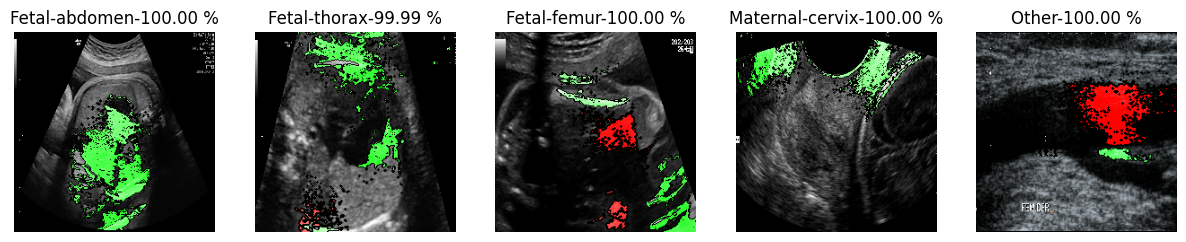

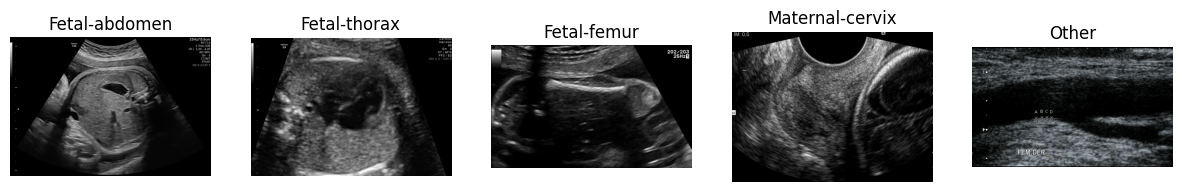

In [ ]:
get_explanations(final_preds,images_to_predict,new_model)